# Step 3: Tumor Segmentation

In this step, we move beyond classification (does this MRI contain a tumor?) to **segmentation** (where exactly is the tumor located)

We’ll use a lightweight U-Net–style model for demonstration

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

In [ ]:
data_path = r"C:\Users\youce\Desktop\MRI_preprocessing_pipeline\data\step2_samples"
image_files = [os.path.join(data_path, f) for f in os.listdir(data_path) if f.endswith(".png")]

imgs = [cv2.resize(cv2.imread(f, cv2.IMREAD_GRAYSCALE), (128,128)) for f in image_files]
X = np.array(imgs) / 255.0
X = np.expand_dims(X, -1)

In [5]:
def simple_unet(input_shape=(128,128,1)):
    inputs = Input(input_shape)

    c1 = Conv2D(16, 3, activation="relu", padding="same")(inputs)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(32, 3, activation="relu", padding="same")(p1)
    p2 = MaxPooling2D()(c2)

    b1 = Conv2D(64, 3, activation="relu", padding="same")(p2)

    u1 = UpSampling2D()(b1)
    m1 = concatenate([u1, c2])
    c3 = Conv2D(32, 3, activation="relu", padding="same")(m1)

    u2 = UpSampling2D()(c3)
    m2 = concatenate([u2, c1])
    c4 = Conv2D(16, 3, activation="relu", padding="same")(m2)

    outputs = Conv2D(1, 1, activation="sigmoid")(c4)

    return Model(inputs, outputs)

model = simple_unet()


In [6]:
masks = np.array([(img > 0.6).astype(np.float32) for img in X])

In [7]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.fit(X, masks, epochs=3, batch_size=1)

Epoch 1/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.3548 - loss: 0.7058
Epoch 2/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9358 - loss: 0.6328
Epoch 3/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9527 - loss: 0.5276


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


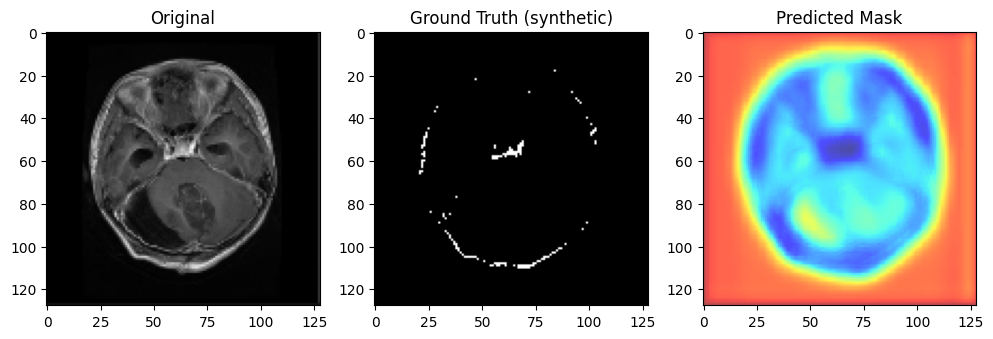

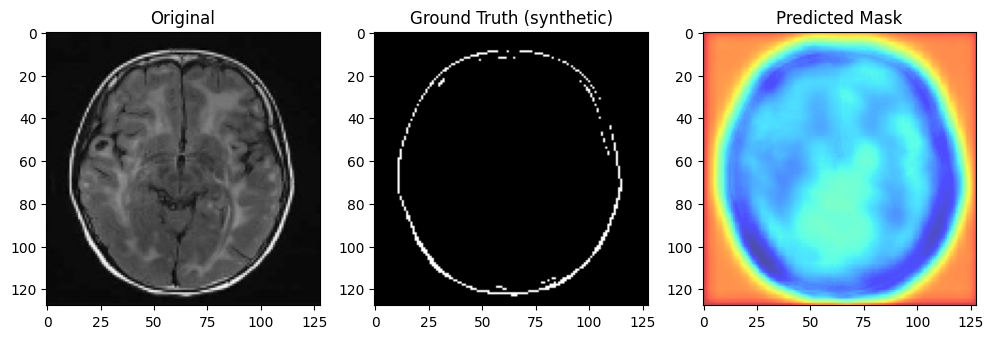

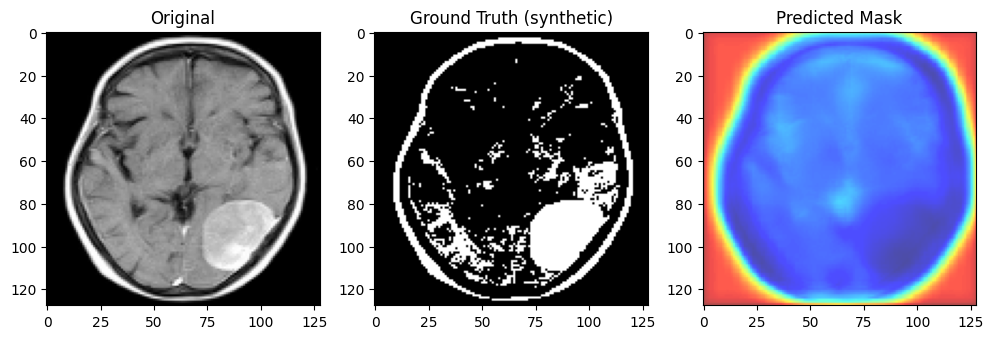

In [8]:
preds = model.predict(X)

for i in range(len(X)):
    fig, axs = plt.subplots(1,3, figsize=(12,4))
    axs[0].imshow(X[i].squeeze(), cmap="gray")
    axs[0].set_title("Original")
    axs[1].imshow(masks[i].squeeze(), cmap="gray")
    axs[1].set_title("Ground Truth (synthetic)")
    axs[2].imshow(preds[i].squeeze(), cmap="jet", alpha=0.7)
    axs[2].set_title("Predicted Mask")
    plt.show()

# Step 3: Tumor Segmentation — Final Notes

In this demo, we applied **2D tumor segmentation** on individual MRI slices using a lightweight U-Net model.  
This allows us to highlight where tumors are likely located in each image, which is a big step forward from Step 2 (classification only).

---

## ✅ What We Did
- Loaded MRI images (`.png` slices).  
- Built a simple U-Net–style model in Keras/TensorFlow.  
- Trained on synthetic masks (demo purpose only).  
- Visualized side-by-side:
  - Original MRI
  - Ground truth mask (synthetic)
  - Predicted mask

---

## 🚀 How to Extend This to 3D Segmentation
For real-world tumor segmentation in MRI volumes:

1. **Datasets**  
   - Use volumetric MRI datasets in **DICOM (`.dcm`)** or **NIfTI (`.nii`)** format.  
   - Examples: [BraTS Challenge Dataset](https://www.med.upenn.edu/cbica/brats2020/data.html).

2. **Preprocessing**  
   - Load volumes using libraries like `nibabel` (for `.nii`) or `pydicom` (for `.dcm`).  
   - Normalize intensities across slices.  
   - Resize volumes to fixed dimensions (e.g., 128×128×64).

3. **Modeling**  
   - Replace `Conv2D` / `MaxPooling2D` / `UpSampling2D` with their **3D equivalents**:
     - `Conv3D`, `MaxPooling3D`, `UpSampling3D`.  
   - Input shape becomes `(height, width, depth, channels)` instead of `(height, width, channels)`.

   Example:
   ```python
   from tensorflow.keras.layers import Conv3D, MaxPooling3D, UpSampling3D

   inputs = Input((128,128,64,1))  # 128x128 slices, 64 depth
   x = Conv3D(16, 3, activation="relu", padding="same")(inputs)
   x = MaxPooling3D()(x)
   # ...